In [155]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
import string
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

In [115]:
data = pd.read_csv('realornot_train.csv')
data_training = pd.DataFrame(data[{'text','target'}])
#data_training
data_training['target'].value_counts()


0    4342
1    3271
Name: target, dtype: int64

In [117]:
data.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [106]:
# Preprocessing data:

def preprocess_tweet(text):

    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    # convert text to lower-case
    nopunc = nopunc.lower()
    # remove URLs
    nopunc = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))', '', nopunc)
    nopunc = re.sub(r'http\S+', '', nopunc)
    # remove usernames
    nopunc = re.sub('@[^\s]+', '', nopunc)
    # remove the # in #hashtag
    nopunc = re.sub(r'#([^\s]+)', r'\1', nopunc)
    # remove repeated characters
    #nopunc = word_tokenize(nopunc)
    # remove stopwords from final word list
    #return [word for word in nopunc if word not in stopwords.words('english')]
    return nopunc

In [124]:
data['clean_text'] = data['text'].apply(lambda x:preprocess_tweet(x))

In [129]:
#data.drop('text',axis = 1, inplace = True)
data.drop('keyword',axis = 1, inplace = True)

In [140]:
data['clean_text'] = data['location'] + ' ' + data['clean_text']
#data.drop('merge',axis = 1, inplace = True)

In [144]:
# Text len of the comments:

data['text_len'] = data['clean_text'].apply(lambda x: len(x) - len(' '))


,id,location,target,clean_text,text_len
0,1,,1,our deeds are the reason of this earthquak...,71
1,4,,1,forest fire near la ronge sask canada,40
2,5,,1,all residents asked to shelter in place ar...,133
3,6,,1,13000 people receive wildfires evacuation ...,66
4,7,,1,just got sent this photo from ruby alaska ...,89


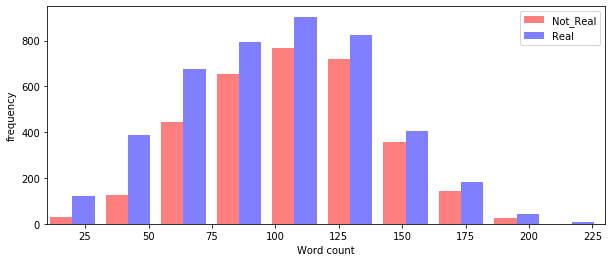

In [224]:
# Word count analysis

a = data['text_len'][data['target'] == 1]
b = data['text_len'][data['target'] == 0]
pyplot.figure(figsize = (10,4))
pyplot.xlim(10,230)
pyplot.xlabel('Word count')
pyplot.ylabel('frequency')
g = pyplot.hist([a, b], color=['r','b'], alpha=0.5, label=['Not_Real','Real'])
pyplot.legend(loc='upper right')

In [152]:
# Average number of words in each class
avg_words_not_real = sum(data[data['target']==1]['text_len'])/len(data[data['target']==1]['text_len'])
avg_words_real = sum(data[data['target']==0]['text_len'])/len(data[data['target']==0]['text_len'])
print(avg_words_not_real)
print(avg_words_real)

print(data['text_len'].max())

107.42250076429227
100.49424228466145
228


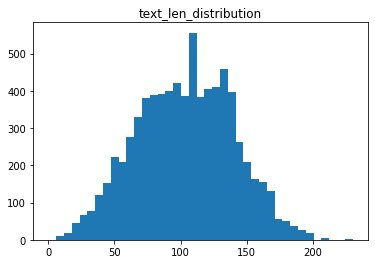

In [153]:
from matplotlib import pyplot
import numpy as np
%matplotlib inline 

bins = np.linspace(0,230,40)
pyplot.hist(data['text_len'],bins)
pyplot.title('text_len_distribution')
pyplot.show()

C:\Users\mayur\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mayur\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.


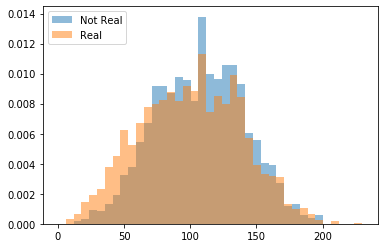

In [154]:
bins = np.linspace(0,230,40)

pyplot.hist(data[data['target']== 1]['text_len'],bins , alpha = 0.5, normed = True,label ='Not Real')
pyplot.hist(data[data['target']== 0]['text_len'],bins , alpha = 0.5, normed = True,label ='Real')
pyplot.legend(loc = 'upper left')
pyplot.show()

In [159]:
# Feature extraction
stopwards = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

def final_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+',text)
    text = [ps.stem(words) for words in tokens if tokens not in stopwards]
    return text

In [275]:
Vector = TfidfVectorizer(analyzer= final_text, max_features= 8000, min_df =5,max_df = 0.7)
X_tfidf    = Vector.fit_transform(data['clean_text']) 
#print(Vector.get_feature_names())

In [276]:
X = X_tfidf.toarray()

In [268]:
## Singular value decomposition 

from numpy import diag
from numpy import zeros
from scipy.linalg import svd

# Singular value decompostion
U,s, VT = svd(X)

# Create m*n Sigma matrix

Sigma = zeros((X.shape[0], X.shape[1]))

# populate Sigma with n x n diagonal matrix
Sigma[:X.shape[0], :X.shape[0]] = diag(s)

# select
n_elements = 500

Sigma = Sigma[:, :n_elements]

VT = VT[:n_elements, :]
# reconstruct

B = U.dot(Sigma.dot(VT))
print(B)

# transform
T = U.dot(Sigma)
#print(T)

T = X.dot(VT.T)
#print(T)




[[ 6.68240512e-02  4.67553812e-04  1.29679702e-03 ... -1.59247428e-04
   7.44721314e-04 -8.25293439e-04]
 [ 7.84686967e-02 -1.38989963e-04 -4.76943925e-04 ... -2.74674370e-04
   1.84347441e-03 -8.21737563e-04]
 [ 4.15535901e-02 -2.50131404e-03 -7.99787771e-04 ... -4.56659683e-04
  -1.33660020e-03  4.96804802e-04]
 ...
 [ 1.47342877e-01 -1.43174738e-02 -6.60050981e-04 ... -1.98602802e-04
   4.51645249e-04  3.72028993e-04]
 [ 4.82084134e-02 -1.39733418e-03 -7.76430802e-04 ... -4.98996642e-04
  -4.50546381e-04 -5.61207512e-04]
 [ 1.61759815e-01 -3.02917834e-04  1.17304419e-04 ... -2.92067575e-04
  -9.45935491e-05 -2.79313073e-05]]


In [285]:
X_features = pd.concat([data['text_len'],pd.DataFrame(X)],axis = 1)

In [286]:
X_features.shape

(7613, 2836)

In [225]:
############

In [288]:
X_features.head()

,text_len,0,1,2,3,4,5,6,7,8,...,2825,2826,2827,2828,2829,2830,2831,2832,2833,2834
0,71,0.084933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40,0.116470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,133,0.047796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,66,0.229743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89,0.139627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [289]:
from sklearn.model_selection import train_test_split

y = data['target']
x = X_features

X_train,X_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state = 0)


In [290]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators= 500, random_state=0,n_jobs= -1)
text_classifier.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [291]:
predictions = text_classifier.predict(X_test)

In [292]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

print( "Accuracy of the model is :",accuracy_score(y_test,predictions))


Accuracy of the model is : 0.7925147734734077
